This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.display import Audio
from torchinfo import summary

#possibly unnecessary:
import torch.nn as nn
import torch.utils.data as data_utils
import logging
from torch import optim
from torchaudio import transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [4]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

def load_langs():
    X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
        "dataset/targets_train_int8.npy"
    )
    X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
        "dataset/targets_test_int8.npy"
    )

    X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = load_langs()

# input
tensor_X_train = torch.from_numpy(X_train)
tensor_X_test = torch.from_numpy(X_test)

# target
tensor_y_train = torch.from_numpy(y_train)
tensor_y_test = torch.from_numpy(y_test)

# One-hot encoding and prep for use in model
BATCH_SIZE = 200

training = tensor_X_train
target_train = tensor_y_train.to(device)
target_train_ohe = nn.functional.one_hot(target_train.long(), 6).float()

test = tensor_X_test
target_test = tensor_y_test.to(device)
target_test_ohe = nn.functional.one_hot(target_test.long(), 6).float()

train_dataset = data_utils.TensorDataset(training, target_train_ohe) # unsqueeze so it gets shape (64, 1, 40, 201)
train_loader = data_utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) 

test_dataset = data_utils.TensorDataset(test, target_test_ohe)
test_loader = data_utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [6]:
# normalization with MFCC

class MFCC_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.sample_rate = 40000/5
        self.transform_MFCC = transforms.MFCC(sample_rate = self.sample_rate)

    def forward(self, x):
        with torch.no_grad():
            x = x.unsqueeze(1)
            x = self.transform_MFCC(x)
        return x


### CNN model multi-class

In [14]:
# Create a sequential model - CNN
# (batch, channel, image height, image width)
    
MFCC_transformation = MFCC_layer()

model = nn.Sequential(MFCC_transformation)

# Add convolutional and pooling layers
model.add_module('Conv_1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1))
model.add_module('Relu_1', nn.ReLU())
model.add_module('BatchNorm_1', nn.BatchNorm2d(num_features=32))

model.add_module('MaxPool_1', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('Relu_2', nn.ReLU())
model.add_module('BatchNorm_2', nn.BatchNorm2d(num_features=64))

model.add_module('MaxPool_2', nn.MaxPool2d(kernel_size=2, padding=1))

model.add_module('Conv_3', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1))
model.add_module('Relu_3', nn.ReLU())
model.add_module('BatchNorm_3', nn.BatchNorm2d(num_features=64))

model.add_module('Conv_4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1))
model.add_module('Relu_4', nn.ReLU())
model.add_module('BatchNorm_4', nn.BatchNorm2d(num_features=128))

#"""""
model.add_module('GlobalPool_1', nn.AvgPool2d(kernel_size=(11,51)))
model.add_module('Flatten', nn.Flatten())
model.add_module('Linear_1', nn.Linear(in_features=128, out_features=6))

model.add_module('Out_activation', nn.Softmax(1))

#"""""

model = model.to(device)

summary(model, input_size=(1,40_000))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 6]                    --
├─MFCC_layer: 1-1                        [1, 1, 40, 201]           --
│    └─MFCC: 2-1                         [1, 1, 40, 201]           --
│    │    └─MelSpectrogram: 3-1          [1, 1, 128, 201]          --
│    │    └─AmplitudeToDB: 3-2           [1, 1, 128, 201]          --
├─Conv2d: 1-2                            [1, 32, 40, 201]          320
├─ReLU: 1-3                              [1, 32, 40, 201]          --
├─BatchNorm2d: 1-4                       [1, 32, 40, 201]          64
├─MaxPool2d: 1-5                         [1, 32, 21, 101]          --
├─Conv2d: 1-6                            [1, 64, 21, 101]          18,496
├─ReLU: 1-7                              [1, 64, 21, 101]          --
├─BatchNorm2d: 1-8                       [1, 64, 21, 101]          128
├─MaxPool2d: 1-9                         [1, 64, 11, 51]           --
├─Conv2d:

In [26]:
LEARNING_RATE = 0.0005
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 
crossentropy_loss = nn.CrossEntropyLoss(reduction='mean')
num_epochs = 50

N_TRAIN = 6000
N_TEST = 1200

model.train() 

iterations = 0
train_accuracies = []
train_losses = []
test_accuracies = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    for images, labels in train_loader: 
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Get the predictions from the model           
        predictions = model(images)

        #  Calculate the loss and backpropagate
        loss = crossentropy_loss(predictions, labels)
        loss.backward() 
        optimizer.step()

        if iterations % 10 == 0:
            model.eval()
            with torch.no_grad():
                outputs_train = []
                train_loss = []
                for images, labels in train_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    predictions = model(images)
                    outputs_train.append(predictions.argmax(dim=1).long())
                    train_loss.append(crossentropy_loss(predictions,labels))
                outputs_train = torch.cat(outputs_train)
                train_accuracy = (outputs_train == target_train).sum().item() / N_TRAIN
                train_accuracy *= 100
                train_accuracies.append(train_accuracy)

                train_loss = sum(train_loss) / N_TRAIN
                train_losses.append(train_loss)

                outputs_test = []
                test_loss = []
                for images, labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    predictions = model(images)
                    outputs_test.append(predictions.argmax(dim=1).long())
                    test_loss.append(crossentropy_loss(predictions,labels))
                outputs_test = torch.cat(outputs_test)
                test_accuracy = (outputs_test == target_test).sum().item() / N_TEST
                test_accuracy *= 100
                test_accuracies.append(test_accuracy)

                test_loss = sum(test_loss) / N_TEST
                test_losses.append(test_loss)

        iterations += 1

In [27]:
print(np.mean(test_accuracies[-BATCH_SIZE:]))

80.62611111111111


<function matplotlib.pyplot.show(close=None, block=None)>

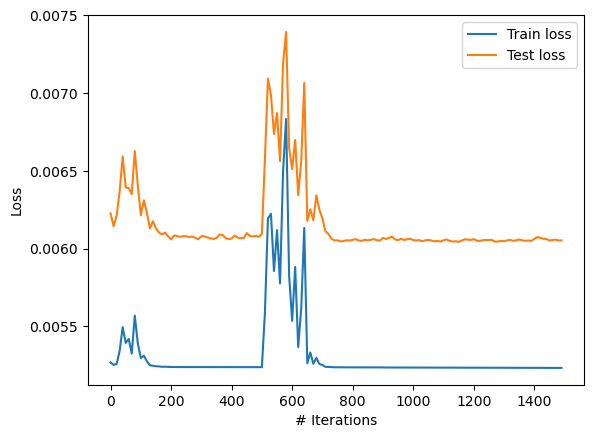

In [24]:
train_losses = list(map(lambda x: x.cpu(), train_losses))
test_losses = list(map(lambda x: x.cpu(), test_losses))

plt.plot(10*np.arange(0, len(train_losses)), train_losses, label='Train loss')
plt.plot(10*np.arange(0, len(test_losses)), test_losses, label='Test loss')
plt.xlabel("# Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

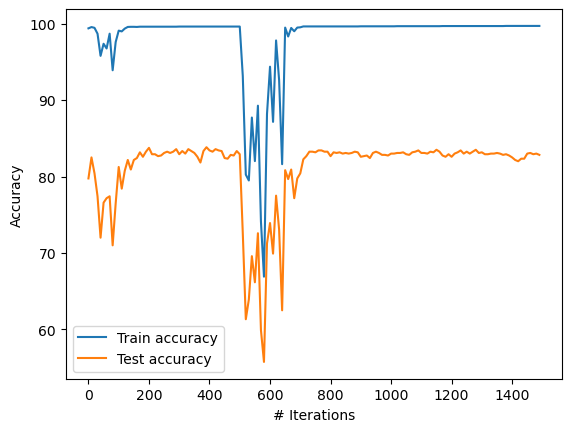

In [23]:
plt.plot(10*np.arange(0, len(train_accuracies)), train_accuracies, label='Train accuracy')
plt.plot(10*np.arange(0, len(test_accuracies)), test_accuracies, label='Test accuracy')
plt.xlabel("# Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [25]:
torch.jit.save(torch.jit.script(model.to("cpu")), f"b{BATCH_SIZE}e{num_epochs}l{LEARNING_RATE}.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [7]:
model = torch.jit.load("b200e50l0.001.pt")

### Making a PCA plot of the output space

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [31]:
test = test.to("cpu")
target_test = target_test.to("cpu")
model = model.to("cpu")

model_outputs = model(test)
targets = target_test

In [27]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs.detach().numpy())

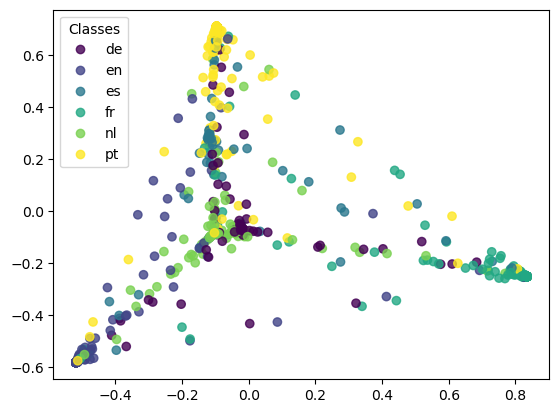

In [43]:
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, alpha=0.8)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);